In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import geopandas as gpd
import sklearn, sklearn.decomposition

# import seaborn as sns
import seaborn.apionly as sns
from matplotlib import rcParams


## Matplotlib has some pretty annoying defaults. The rest of this cell is to
## produce nice plots, for my definition of nice

plt.style.use('seaborn-darkgrid')

rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 10
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'
rcParams['axes.titlesize'] = 11

rcParams['savefig.dpi'] = 150
rcParams['figure.dpi'] = 150

import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

%config InlineBackend.figure_format='retina'

# Section 1: Load data and explore

In [2]:
tzdf = gpd.read_file('../shapefiles/taxi_zones.shp').drop(['OBJECTID', 'Shape_Area', 'Shape_Leng'], axis=1)
tzdf = tzdf.to_crs({'init': 'epsg:3857'})

In [3]:
import fastparquet
dropoffs_matrix = fastparquet.ParquetFile('/data/trips_dropoffs_matrix.parquet').to_pandas()
pickups_matrix = fastparquet.ParquetFile('/data/trips_pickups_matrix.parquet').to_pandas()

In [4]:
# drop last three columns that indicate unknown taxi zone for the trip
dropoffs_matrix = dropoffs_matrix.iloc[:, :-3]
pickups_matrix = pickups_matrix.iloc[:, :-3]

In [5]:
dropoffs_matrix.to_csv('/data/trips_dropoffs_matrix.csv', index=False)
pickups_matrix.to_csv('/data/pickups_matrix.csv', index=False)

In [6]:
# concat along the taxizone_id dimension. This effectively makes a 526 column 
# dataframe that has both pickup and dropoff information. 
counts_matrix = pd.concat([dropoffs_matrix, pickups_matrix], axis=1 )

In [7]:
counts_matrix.head()

1  2  3    4  5  6    7  8  9  10 ...   254  255  256  \
index                                                   ...                   
2009-01-01 00:00:00   0  0  1  128  0  1  113  0  0   1 ...     0   74   53   
2009-01-01 01:00:00   2  0  2  154  0  1  188  2  1   0 ...     0   97   92   
2009-01-01 02:00:00   3  0  1  134  1  0  245  0  4   4 ...     0  122  115   
2009-01-01 03:00:00   1  0  1  109  0  0  229  0  4   1 ...     0   80   98   
2009-01-01 04:00:00  10  0  2  103  0  0  221  1  3   2 ...     0   80   74   

                     257  258  259  260  261  262  263  
index                                                   
2009-01-01 00:00:00    4    2    0    6   70  179  449  
2009-01-01 01:00:00    7    0    0   22   85  239  627  
2009-01-01 02:00:00    6    1    0   21   55  170  594  
2009-01-01 03:00:00    5    1    0   28   70   96  437  
2009-01-01 04:00:00    5    0    0   20   37   62  296  

[5 rows x 526 columns]

In [8]:
counts_matrix.to_csv('/data/counts_matrix.csv', index=False)

In [9]:
zz = pd.DataFrame(dropoffs_matrix.sum(axis=0).sort_values(ascending=False))
zz.index = zz.index.astype(np.int32)
zz.columns = ["N_dropoffs"]

### Top 15 Dropoff taxizones
Notice all are in Manhattan

In [10]:
from IPython.display import HTML
HTML(zz.merge(tzdf, left_index=True, right_on='LocationID').iloc[:15].to_html())

### Top 15 Dropoff taxizones
Manhattan specifically excluded

In [11]:
HTML(zz.merge(tzdf[tzdf.borough != 'Manhattan'], left_index=True, right_on='LocationID').iloc[:15].to_html())

### A plot of a few particular taxi districts

In [12]:
def plot_zone(tzid=160, ax=None, xl=True, yl=True):
    sns.distplot(counts_matrix.iloc[:, tzid-1], kde=False, label='pickups', ax=ax)
    sns.distplot(counts_matrix.iloc[:, 263+tzid-1], kde=False, color='gray', label='dropoffs', ax=ax)
    if ax is not None:
        plt.sca(ax)
    plt.legend()
    plt.title(tzdf.loc[tzid-1]['zone'])
    if xl:
        plt.xlabel("Hourly Pickups or Dropoffs")
    else:
        plt.xlabel("")
    if yl:
        plt.ylabel('N')
    else:
        plt.ylabel("")

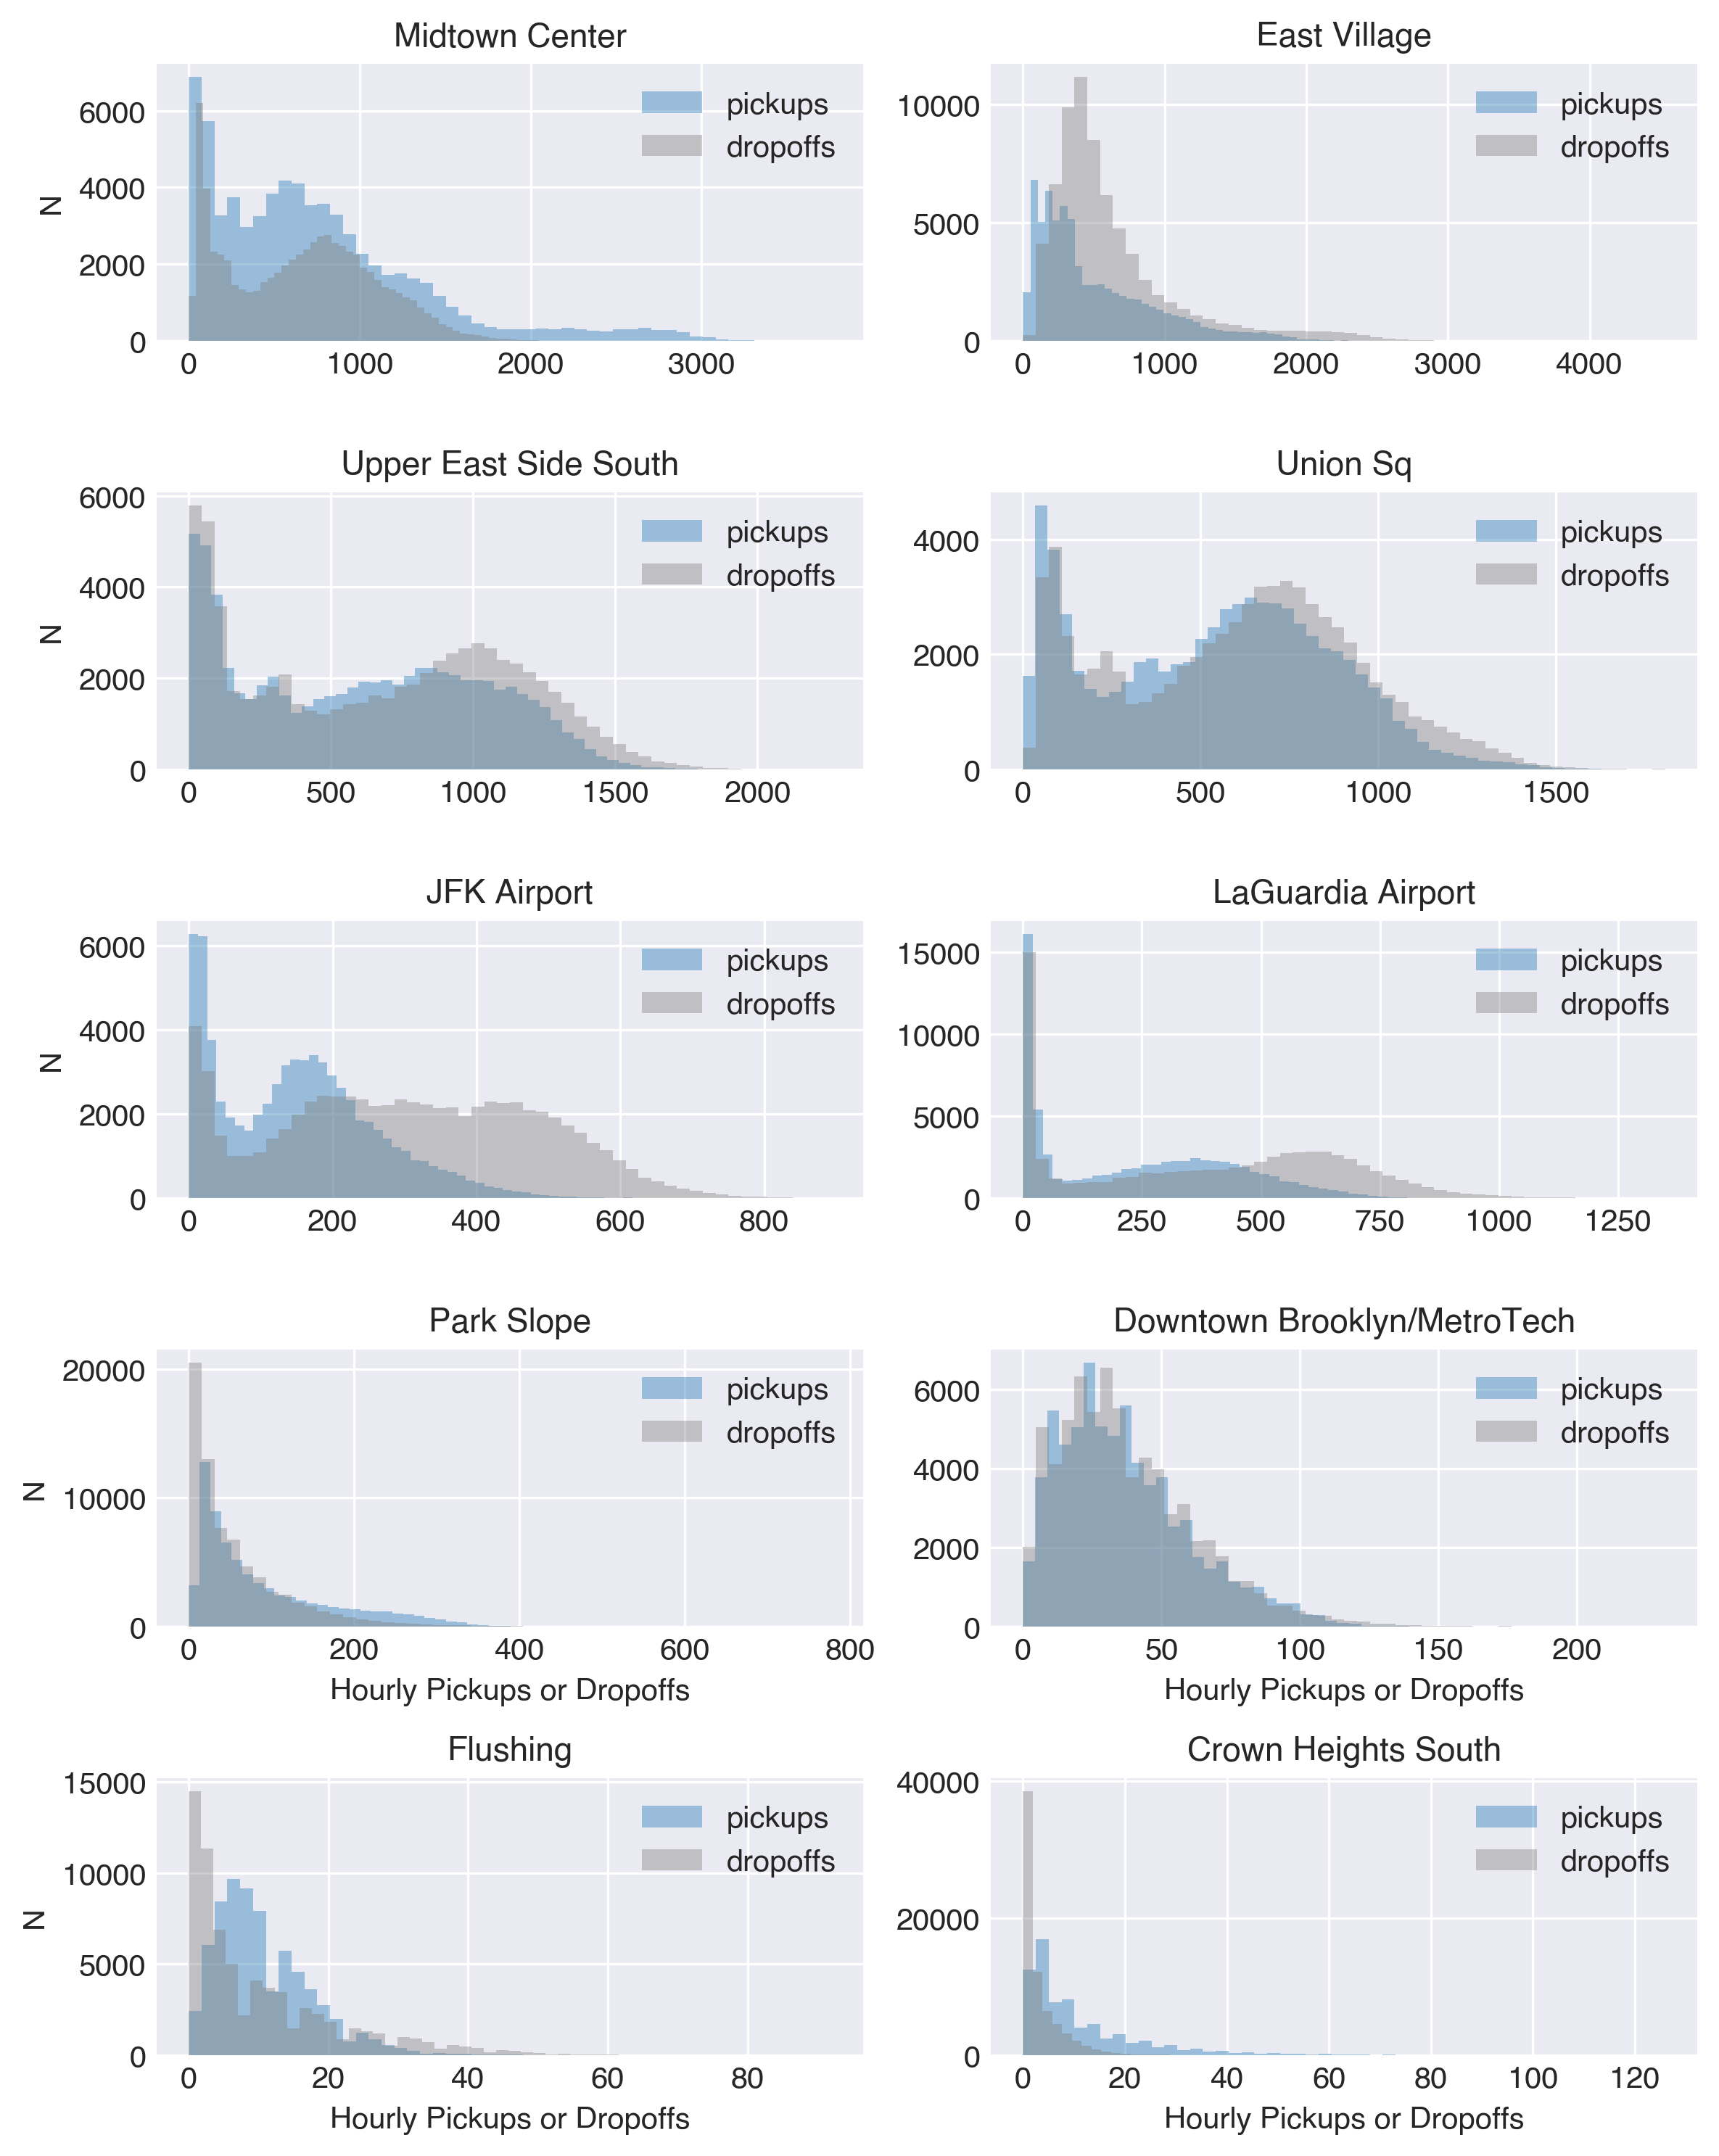

In [13]:
f, axlist = plt.subplots(5, 2)

ids = [161, 79, 237, 234, 132, 138, 181, 65, 92, 62]

for j, (i, ax) in enumerate(zip(ids, axlist.ravel())):
    plot_zone(i, ax=ax, 
              xl=(j >= 6),
              yl=(j%2 == 0)
             )

plt.gcf().set_size_inches(8, 10)
plt.tight_layout()

# PCA / ICA / NMF Decomposition Attempts

Looking at the distributions of pickups for 10 arbitrary taxi zones above, it is clear that one type of distribution (probably) cannot explain all the different distributions of pickups and dropoffs. Let's try a few different types of PCA, ICA, and NMF decompositions. The `pickups_matrix`, `dropoffs_matrix`, or compbined `counts_matrix`, have one axis of the matrix represent time, and the other axis represent space, so the matrix decompositions will reflect a similar duality in spatial structure. 

In [14]:
pickups_matrix.head()

1  2  3    4  5  6    7  8  9  10 ...   254  255  256  \
index                                                  ...                   
2009-01-01 00:00:00  0  0  0  121  0  0   42  0  0   0 ...     0   74   53   
2009-01-01 01:00:00  1  0  0  137  0  0   88  0  0   0 ...     0   97   92   
2009-01-01 02:00:00  1  0  0  125  0  0  115  0  0   0 ...     0  122  115   
2009-01-01 03:00:00  0  0  0  124  0  0  110  1  1   0 ...     0   80   98   
2009-01-01 04:00:00  2  0  0  100  0  0  105  0  1   0 ...     0   80   74   

                     257  258  259  260  261  262  263  
index                                                   
2009-01-01 00:00:00    4    2    0    6   70  179  449  
2009-01-01 01:00:00    7    0    0   22   85  239  627  
2009-01-01 02:00:00    6    1    0   21   55  170  594  
2009-01-01 03:00:00    5    1    0   28   70   96  437  
2009-01-01 04:00:00    5    0    0   20   37   62  296  

[5 rows x 263 columns]

In [15]:
dropoffs_matrix.head()

1  2  3    4  5  6    7  8  9  10 ...   254  255  256  \
index                                                   ...                   
2009-01-01 00:00:00   0  0  1  128  0  1  113  0  0   1 ...     0   85   75   
2009-01-01 01:00:00   2  0  2  154  0  1  188  2  1   0 ...     1  103   84   
2009-01-01 02:00:00   3  0  1  134  1  0  245  0  4   4 ...     0   92   98   
2009-01-01 03:00:00   1  0  1  109  0  0  229  0  4   1 ...     2   59   81   
2009-01-01 04:00:00  10  0  2  103  0  0  221  1  3   2 ...     3   62   84   

                     257  258  259  260  261  262  263  
index                                                   
2009-01-01 00:00:00   13    6    3   36  111  282  450  
2009-01-01 01:00:00   22    7    7   41   75  346  627  
2009-01-01 02:00:00   28    3    4   53   66  283  536  
2009-01-01 03:00:00   24    8    5   56   89  233  448  
2009-01-01 04:00:00   20    4    6   52   68  143  291  

[5 rows x 263 columns]

## Naive PCA

In [16]:
pca_pickup = sklearn.decomposition.PCA(n_components=5)
pickups_pcs = pca_pickup.fit_transform(pickups_matrix.values)
pca_pickup.explained_variance_ratio_

array([ 0.6525235 ,  0.19236085,  0.04518883,  0.01969177,  0.0167445 ])

In [17]:
pca_pickup = sklearn.decomposition.PCA(n_components=5, whiten=True)
pickups_pcs = pca_pickup.fit_transform(pickups_matrix.values)
pca_pickup.explained_variance_ratio_

array([ 0.6525235 ,  0.19236085,  0.04518883,  0.01969177,  0.0167445 ])

In [18]:
pickup_eof1 = pca_pickup.components_[0]
pickup_eof2 = pca_pickup.components_[1]
pickup_eof3 = pca_pickup.components_[2]
pickup_eof4 = pca_pickup.components_[3]
pickup_eof5 = pca_pickup.components_[4]

In [19]:
tzdf['pEOF1'] = pickup_eof1
tzdf['pEOF2'] = pickup_eof2
tzdf['pEOF3'] = pickup_eof3
tzdf['pEOF4'] = pickup_eof4
tzdf['pEOF5'] = pickup_eof5

In [20]:
tzdf.head()

LocationID        borough  \
0           1            EWR   
1           2         Queens   
2           3          Bronx   
3           4      Manhattan   
4           5  Staten Island   

                                            geometry                     zone  \
0  POLYGON ((-8258175.532737532 4967457.202992616...           Newark Airport   
1  (POLYGON ((-8217980.621910957 4959237.28547167...              Jamaica Bay   
2  POLYGON ((-8220713.534155379 4993383.154018582...  Allerton/Pelham Gardens   
3  POLYGON ((-8234500.226961649 4971984.093397928...            Alphabet City   
4  POLYGON ((-8257036.10884249 4948033.094989426,...            Arden Heights   

      pEOF1     pEOF2     pEOF3     pEOF4     pEOF5  
0  0.000190 -0.000846  0.000280 -0.000257  0.001303  
1  0.000069  0.000035 -0.000006 -0.000256 -0.000235  
2  0.000041  0.000004  0.000100  0.000312  0.000335  
3  0.014967  0.052920  0.046970 -0.025640  0.000473  
4  0.000004  0.000005 -0.000002 -0.000016 -0.000006

In [21]:
tzdf2 = tzdf.copy()
tzdf2 = tzdf2[(tzdf2.borough != 'Staten Island') & (tzdf2.borough != 'EWR')]

In [22]:
tzdf2.iloc[:, -5:].describe()

pEOF1       pEOF2       pEOF3       pEOF4       pEOF5
count  242.000000  242.000000  242.000000  242.000000  242.000000
mean     0.026131    0.006993    0.006632    0.011919    0.008212
std      0.058853    0.064033    0.064072    0.063299    0.063888
min     -0.002833   -0.280135   -0.448488   -0.186421   -0.360792
25%      0.000066   -0.000079    0.000005   -0.000013    0.000024
50%      0.000315    0.000036    0.000400    0.001285    0.001235
75%      0.008549    0.001588    0.005123    0.010949    0.013316
max      0.304526    0.569635    0.304542    0.555637    0.314465

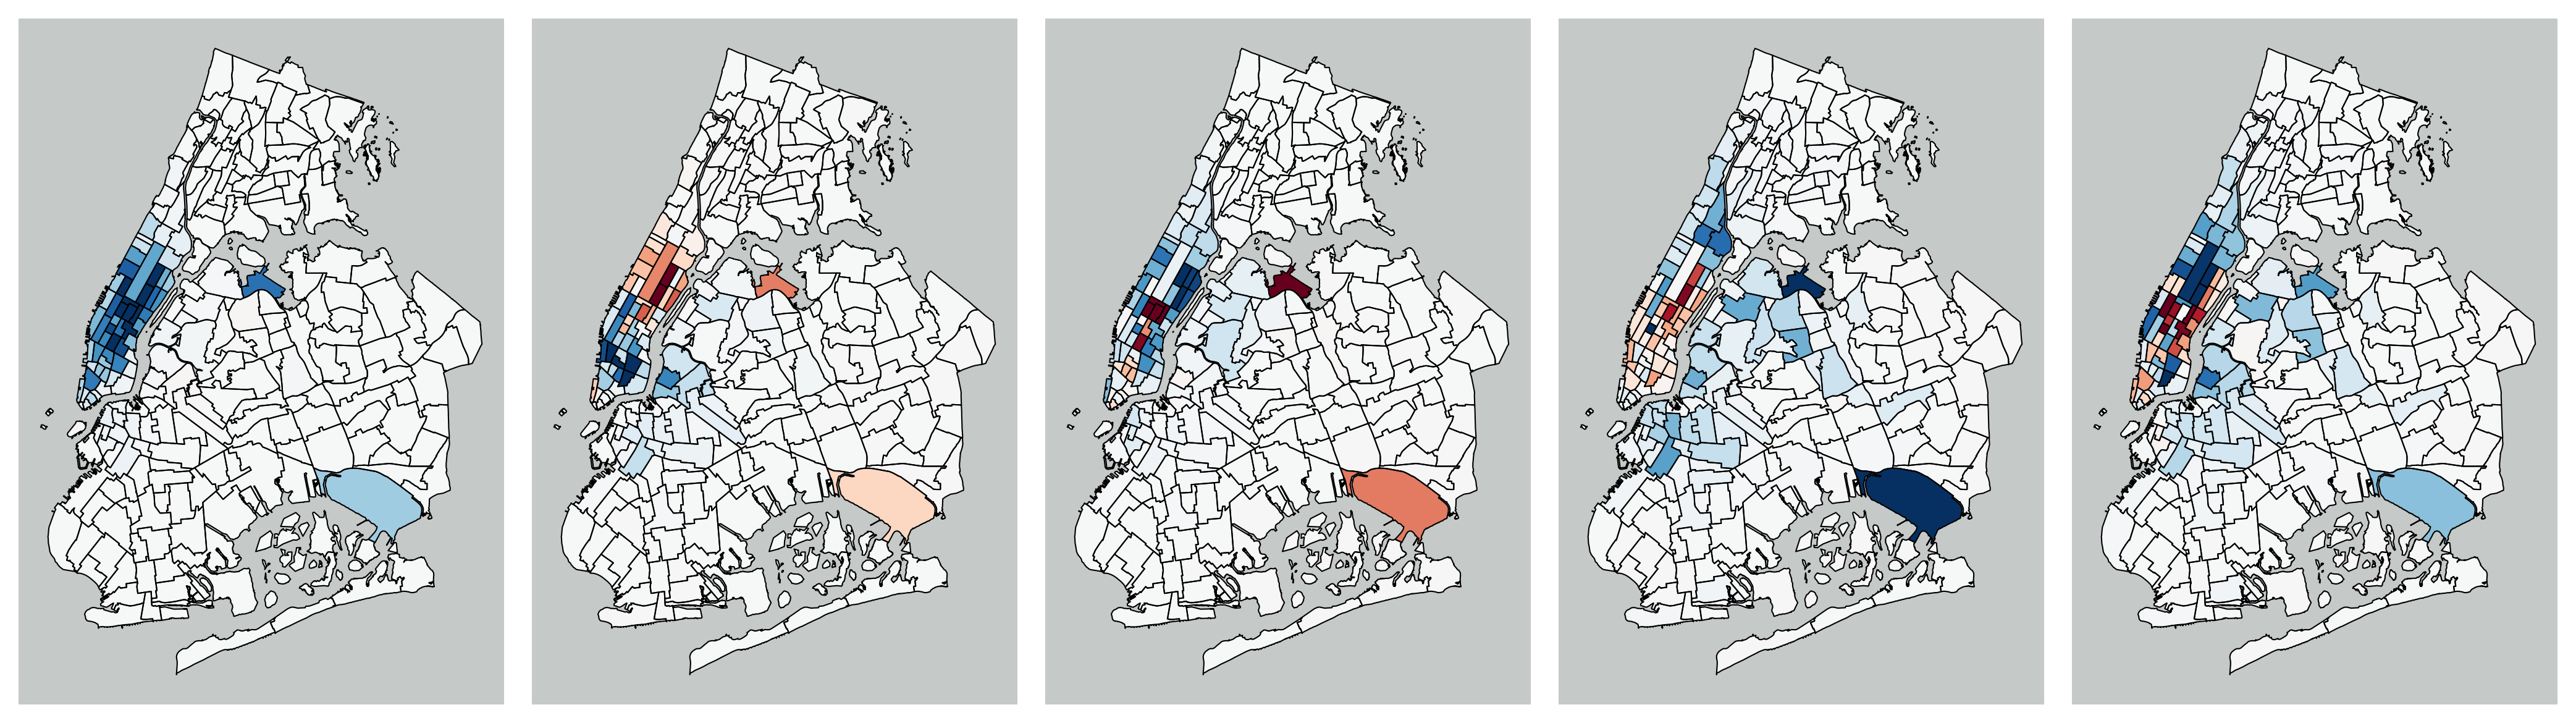

In [23]:
fig, axlist = plt.subplots(1, 5)
for i, ax in enumerate(axlist.ravel()):
    tzdf2.plot(figsize=(8, 8), alpha=1, column='pEOF{}'.format(i+1), cmap=plt.cm.RdBu, edgecolor='k',
          linewidth=0.5, vmin=-0.2, vmax=0.2, ax=ax)
    ax.grid(False)
    ax.set_facecolor('xkcd:silver')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect('equal', 'datalim')
fig.set_size_inches(14, 4)
plt.tight_layout()

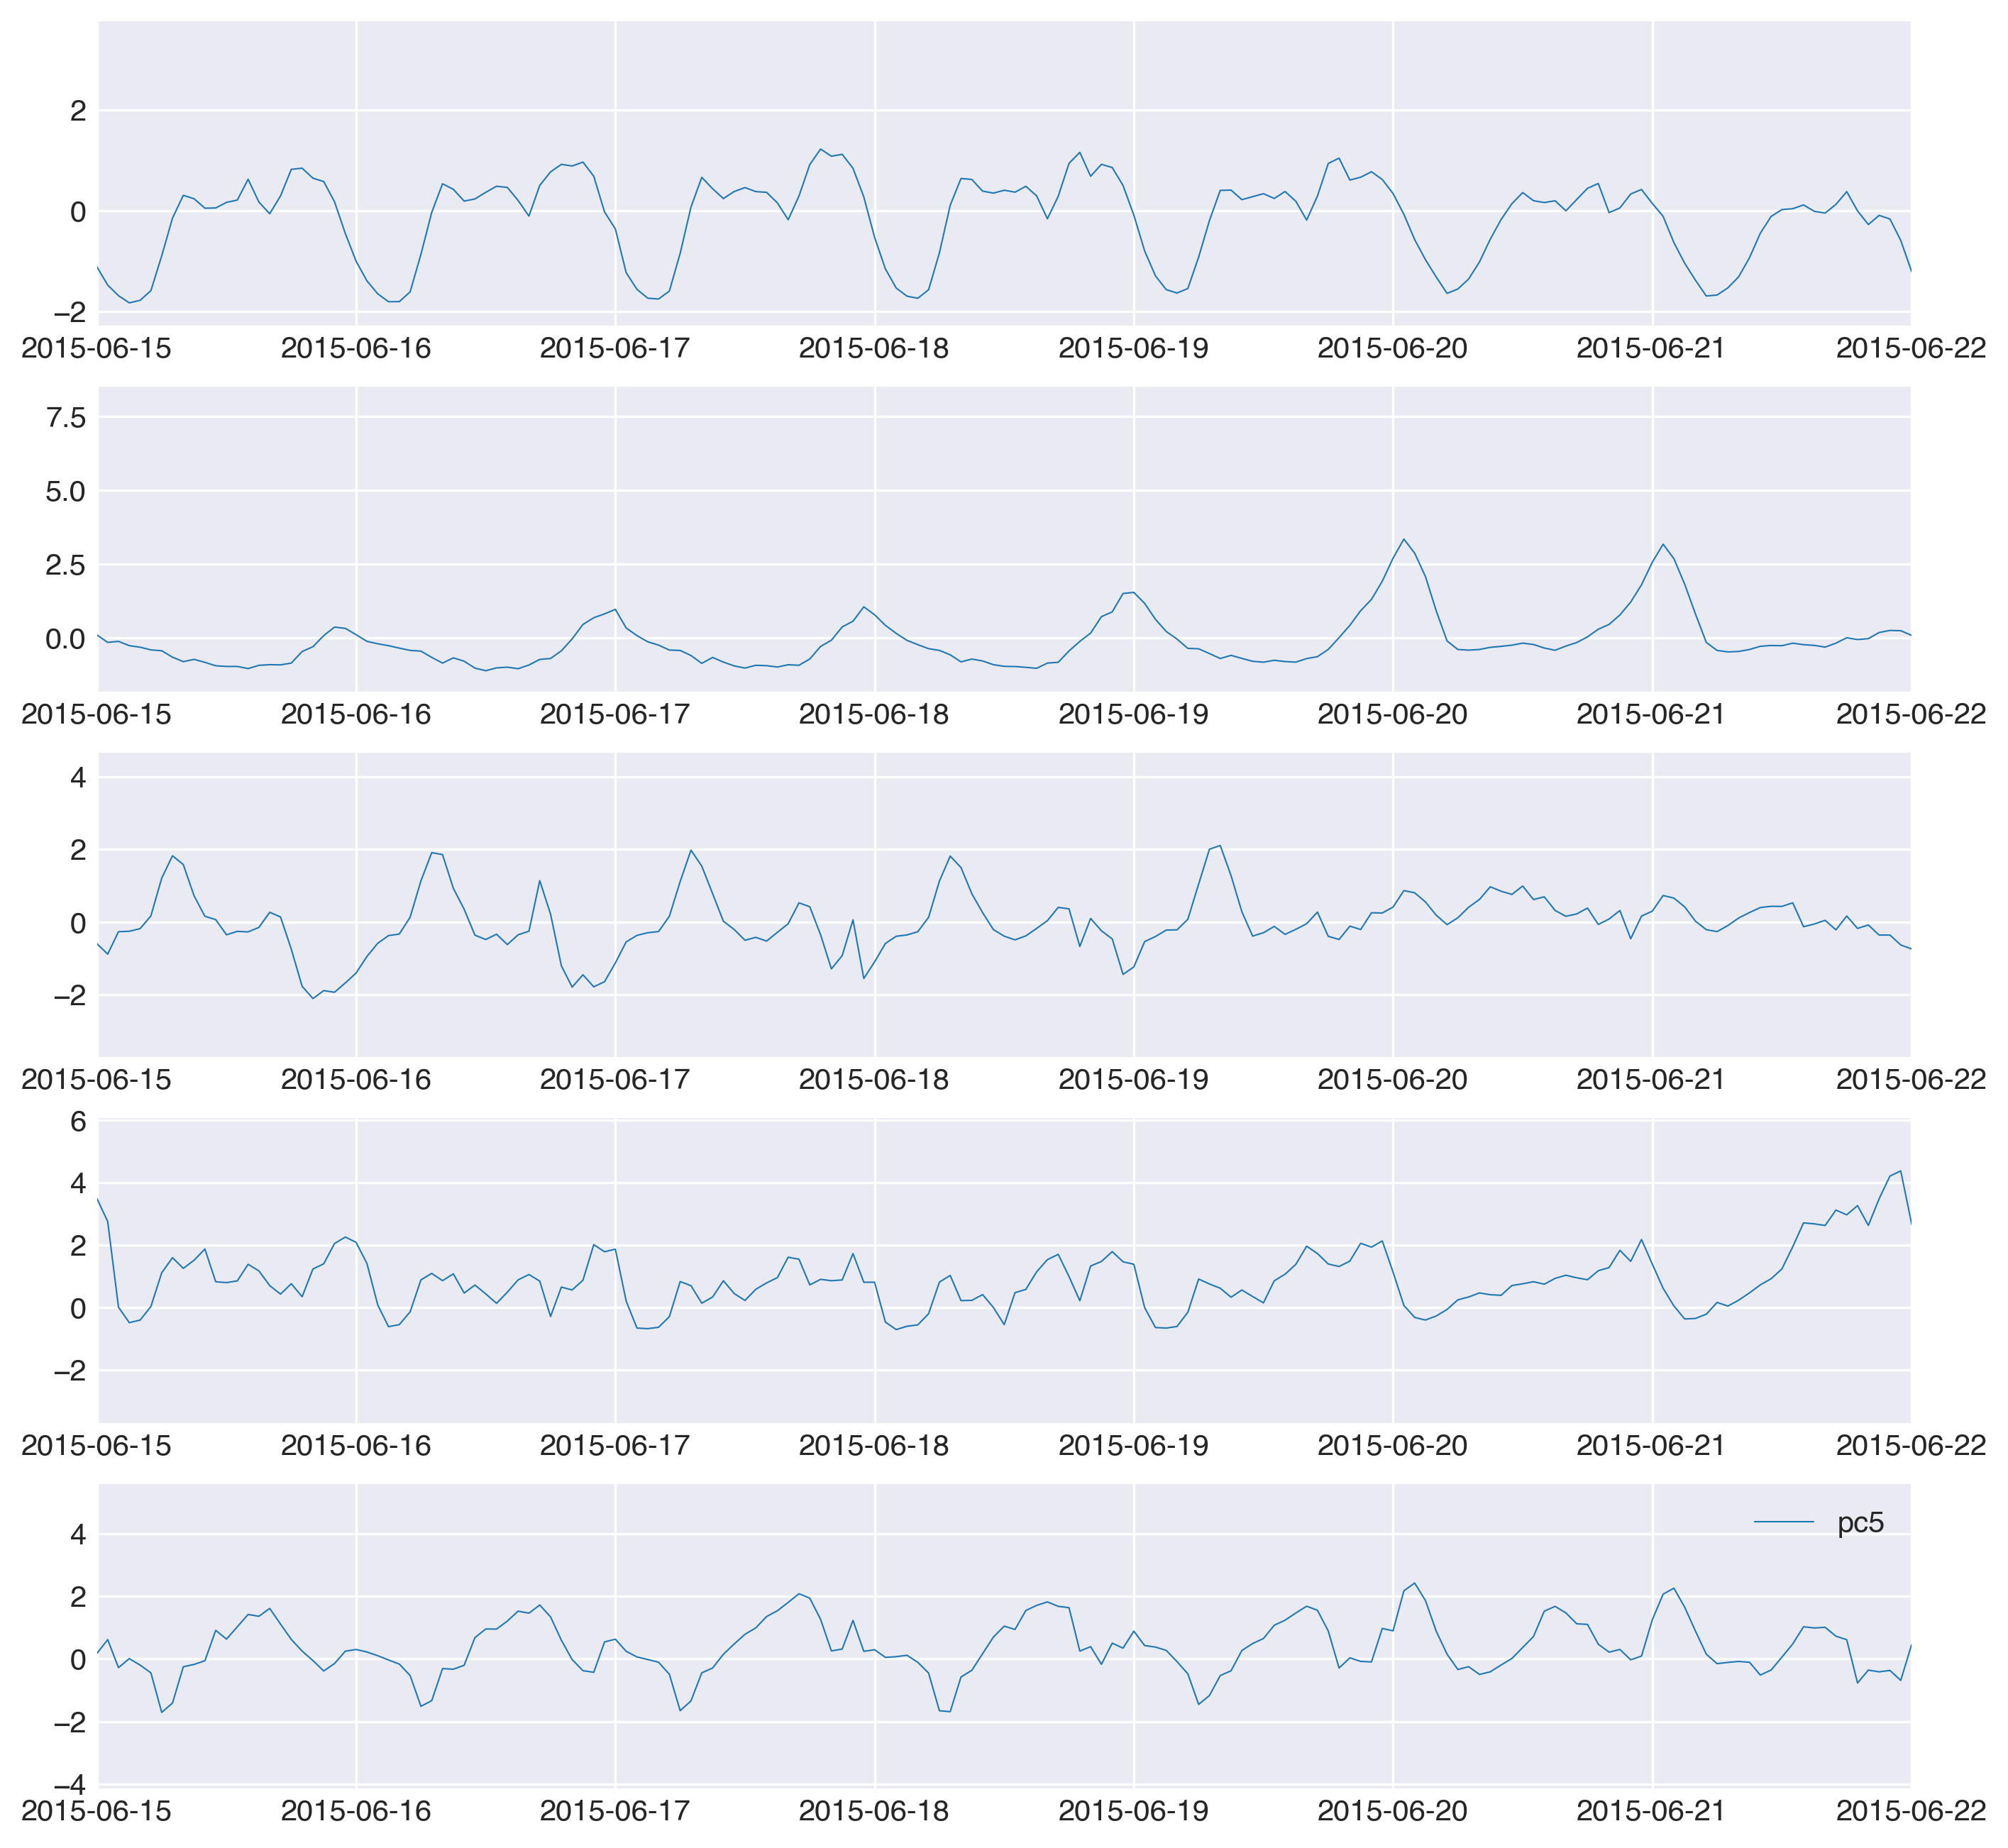

In [24]:
for i, y in enumerate(pickups_pcs.T[:]):
    plt.subplot(5, 1, i+1)
    plt.plot(pickups_matrix.index.values, y, label='pc{}'.format(i+1), lw=0.5)
    plt.xlim('2015-06-15', '2015-06-22')
plt.gcf().set_size_inches(11, 11)
plt.legend()
# plt.xlim('2014-01-01', '2014-07-01')

### Fast ICA

In [25]:
pca_pickup = sklearn.decomposition.FastICA(n_components=5)
pickups_pcs = pca_pickup.fit_transform(pickups_matrix.values)
# pca_pickup.explained_variance_ratio_

In [26]:
pickup_eof1 = pca_pickup.components_[0]
pickup_eof2 = pca_pickup.components_[1]
pickup_eof3 = pca_pickup.components_[2]
pickup_eof4 = pca_pickup.components_[3]
pickup_eof5 = pca_pickup.components_[4]

In [27]:
tzdf['pEOF1'] = pickup_eof1
tzdf['pEOF2'] = pickup_eof2
tzdf['pEOF3'] = pickup_eof3
tzdf['pEOF4'] = pickup_eof4
tzdf['pEOF5'] = pickup_eof5

In [28]:
tzdf.head()

LocationID        borough  \
0           1            EWR   
1           2         Queens   
2           3          Bronx   
3           4      Manhattan   
4           5  Staten Island   

                                            geometry                     zone  \
0  POLYGON ((-8258175.532737532 4967457.202992616...           Newark Airport   
1  (POLYGON ((-8217980.621910957 4959237.28547167...              Jamaica Bay   
2  POLYGON ((-8220713.534155379 4993383.154018582...  Allerton/Pelham Gardens   
3  POLYGON ((-8234500.226961649 4971984.093397928...            Alphabet City   
4  POLYGON ((-8257036.10884249 4948033.094989426,...            Arden Heights   

          pEOF1         pEOF2         pEOF3         pEOF4         pEOF5  
0  1.011461e-08 -6.660147e-09  1.015878e-08 -1.687143e-08  5.599168e-09  
1 -8.827358e-11  5.552652e-10 -2.273537e-09  4.105658e-09  3.441241e-09  
2 -3.322515e-10 -1.408956e-09  3.025205e-09 -5.944370e-09 -3.772628e-09  
3 -1.811558e-07 -4.215255e-07 -2.436830e-07 -6.394212e-08  4.739039e-07  
4  6.978993e-11 -3.533233e-11 -6.808323e-11  1.730704e-10  2.038738e-10

In [29]:
tzdf2 = tzdf.copy()
tzdf2 = tzdf2[(tzdf2.borough != 'Staten Island') & (tzdf2.borough != 'EWR')]

In [30]:
tzdf2.iloc[:, -5:].describe()

pEOF1         pEOF2         pEOF3         pEOF4         pEOF5
count  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02  2.420000e+02
mean  -1.053331e-07 -6.192474e-08  1.147599e-07 -1.625754e-07 -1.218586e-07
std    7.702525e-07  5.883781e-07  6.077089e-07  8.887209e-07  8.945301e-07
min   -6.058296e-06 -4.027633e-06 -2.629512e-06 -4.746138e-06 -7.995341e-06
25%   -4.006033e-08 -5.022617e-08  5.008670e-11 -2.247355e-07 -1.267315e-07
50%   -2.493026e-09 -4.479310e-09  1.168326e-08 -3.089410e-08 -1.525424e-08
75%    2.088510e-10 -5.765840e-11  1.295504e-07 -5.225069e-10  3.074416e-10
max    3.677464e-06  3.678675e-06  3.199434e-06  4.462400e-06  3.634492e-06

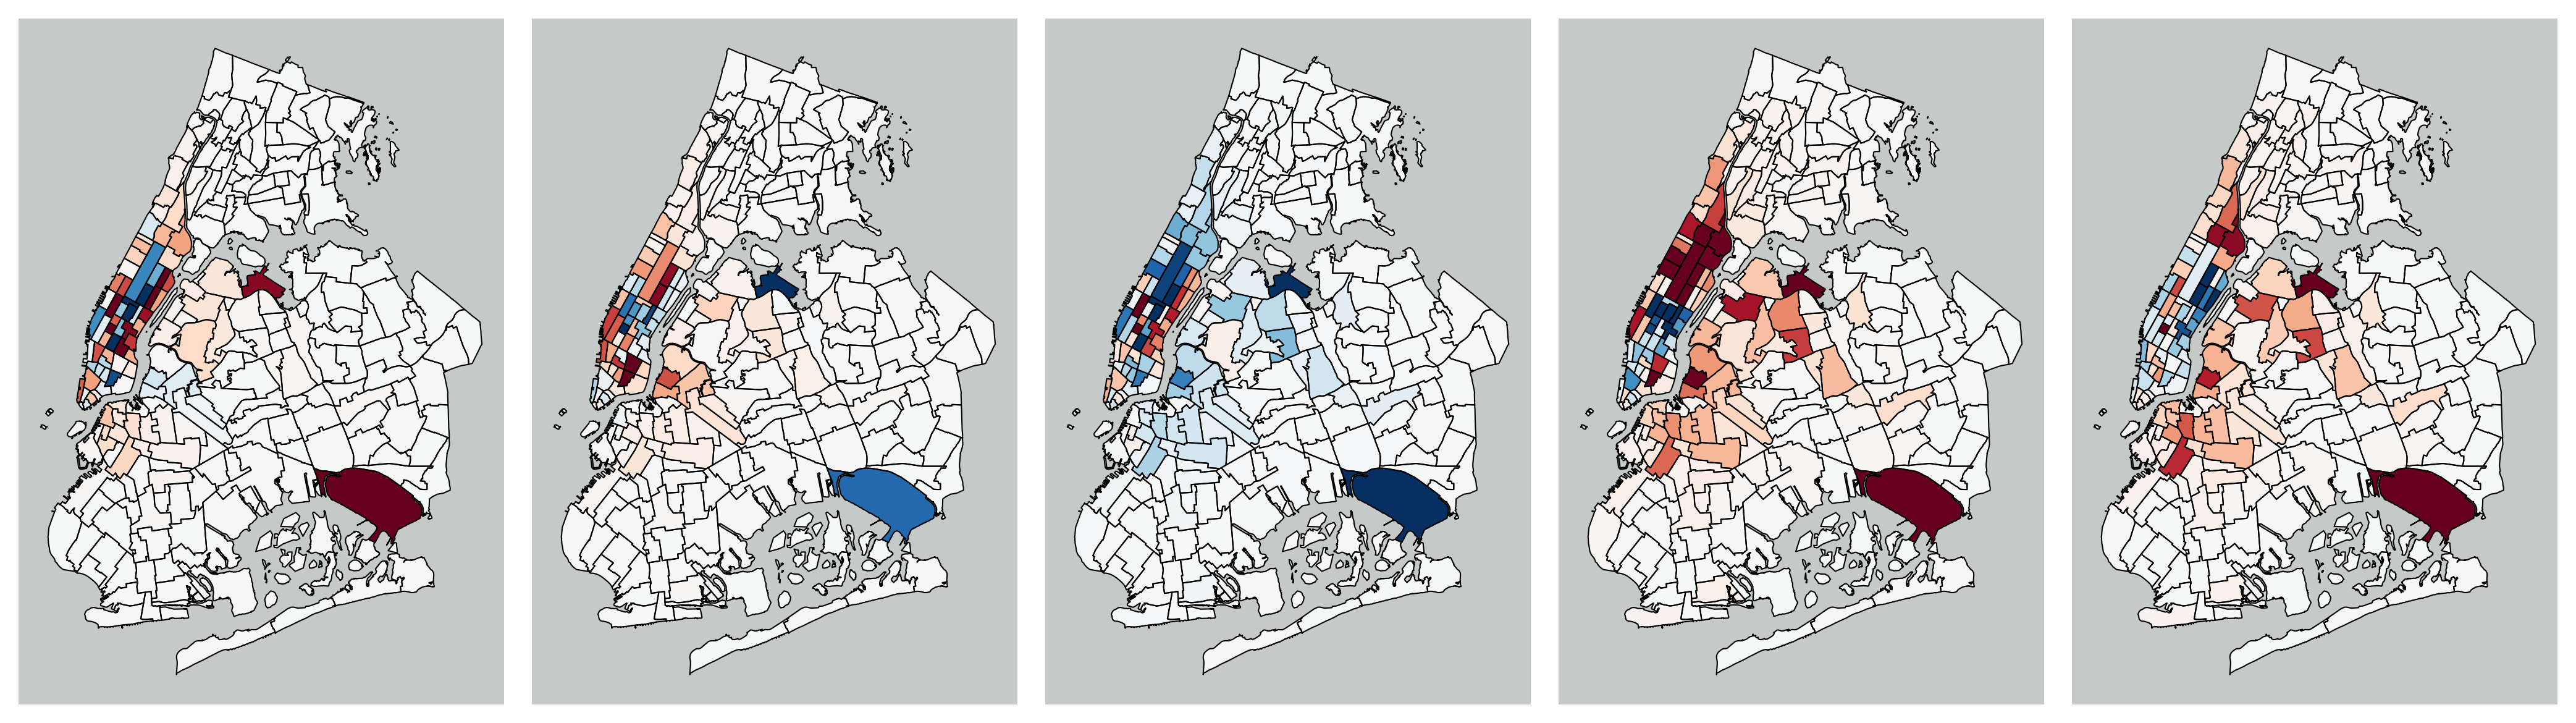

In [31]:
fig, axlist = plt.subplots(1, 5)
for i, ax in enumerate(axlist.ravel()):
    tzdf2.plot(figsize=(8, 8), alpha=1, column='pEOF{}'.format(i+1), cmap=plt.cm.RdBu, edgecolor='k',
          linewidth=0.5, vmin=-0.2e-5, vmax=0.2e-5, ax=ax)
    ax.grid(False)
    ax.set_facecolor('xkcd:silver')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect('equal', 'datalim')
fig.set_size_inches(14, 4)
plt.tight_layout()

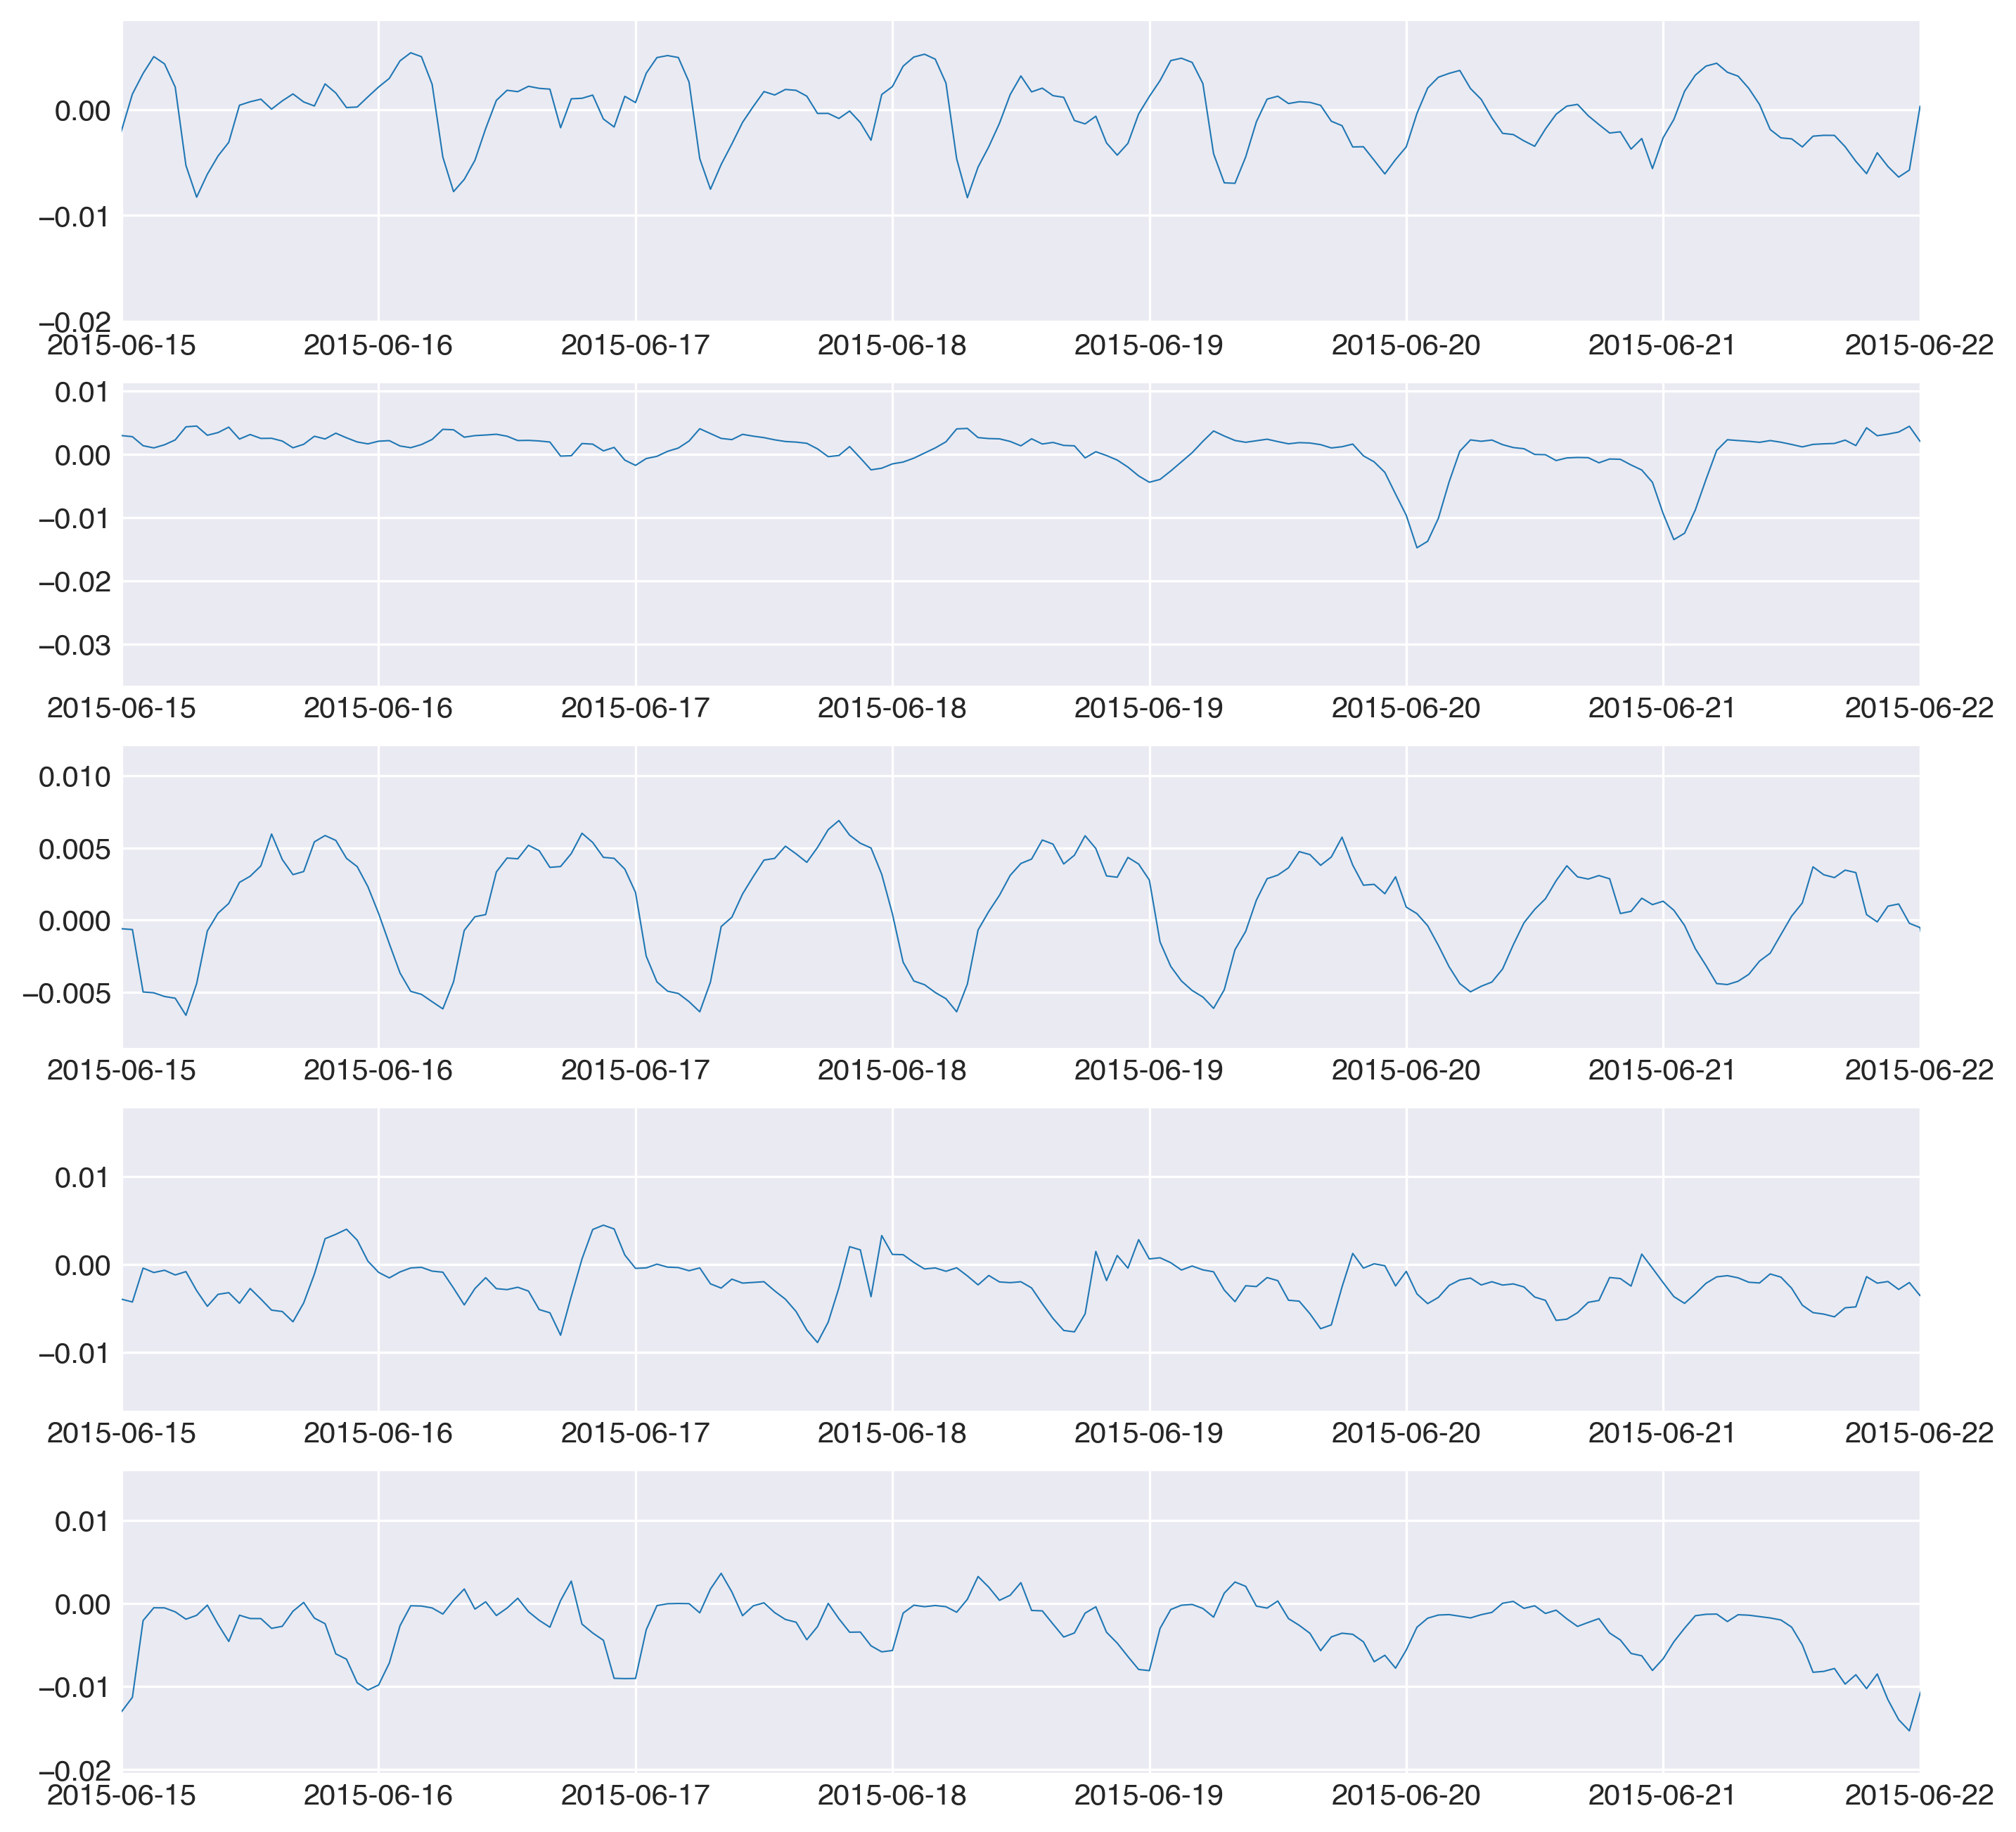

In [32]:
for i, y in enumerate(pickups_pcs.T[:]):
    plt.subplot(5, 1, i+1)
    plt.plot(pickups_matrix.index.values, y, label='pc{}'.format(i+1), lw=0.5)
    plt.xlim('2015-06-15', '2015-06-22')
plt.gcf().set_size_inches(11, 11)
# plt.xlim('2014-01-01', '2014-07-01')

### Sparse PCA

In [33]:
pca_pickup = sklearn.decomposition.SparsePCA(n_components=5, random_state=11, alpha=10)
pickups_pcs = pca_pickup.fit_transform(pickups_matrix.values)
# pca_pickup.explained_variance_ratio_

In [34]:
pickup_eof1 = pca_pickup.components_[0]
pickup_eof2 = pca_pickup.components_[1]
pickup_eof3 = pca_pickup.components_[2]
pickup_eof4 = pca_pickup.components_[3]
pickup_eof5 = pca_pickup.components_[4]

In [35]:
tzdf['pEOF1'] = pickup_eof1
tzdf['pEOF2'] = pickup_eof2
tzdf['pEOF3'] = pickup_eof3
tzdf['pEOF4'] = pickup_eof4
tzdf['pEOF5'] = pickup_eof5

In [36]:
tzdf.head()

LocationID        borough  \
0           1            EWR   
1           2         Queens   
2           3          Bronx   
3           4      Manhattan   
4           5  Staten Island   

                                            geometry                     zone  \
0  POLYGON ((-8258175.532737532 4967457.202992616...           Newark Airport   
1  (POLYGON ((-8217980.621910957 4959237.28547167...              Jamaica Bay   
2  POLYGON ((-8220713.534155379 4993383.154018582...  Allerton/Pelham Gardens   
3  POLYGON ((-8234500.226961649 4971984.093397928...            Alphabet City   
4  POLYGON ((-8257036.10884249 4948033.094989426,...            Arden Heights   

          pEOF1         pEOF2        pEOF3        pEOF4       pEOF5  
0   -359.609481   -129.557848   -34.686735   -46.856016   77.462518  
1    -42.479373      0.000000     0.000000     4.546199    0.000000  
2    -43.616401      0.000000    -0.729936   -20.931008    9.048270  
3 -18690.477425  10266.690900 -3793.638589  1768.231036  362.851097  
4      0.000000      0.000000     0.000000     0.000000    0.000000

In [37]:
tzdf2 = tzdf.copy()
tzdf2 = tzdf2[(tzdf2.borough != 'Staten Island') & (tzdf2.borough != 'EWR')]

In [38]:
tzdf2.iloc[:, -5:].describe()

pEOF1          pEOF2         pEOF3         pEOF4         pEOF5
count     242.000000     242.000000    242.000000    242.000000    242.000000
mean   -22257.706097     818.266274   -195.621151  -1267.135739    426.805824
std     46971.905586   12773.728639   6199.662273   4470.362359   3785.564924
min   -208851.472277  -61336.008504 -25193.634974 -39442.401033 -22102.569752
25%    -10599.141648      -0.785347   -239.434541  -1079.998212      0.000000
50%      -447.223489       0.105106    -19.591950   -161.589938     49.440516
75%      -105.796168     375.032304      0.000000      0.000000    610.123720
max         0.000000  109370.939153  45921.967284   8279.389433  23117.667194

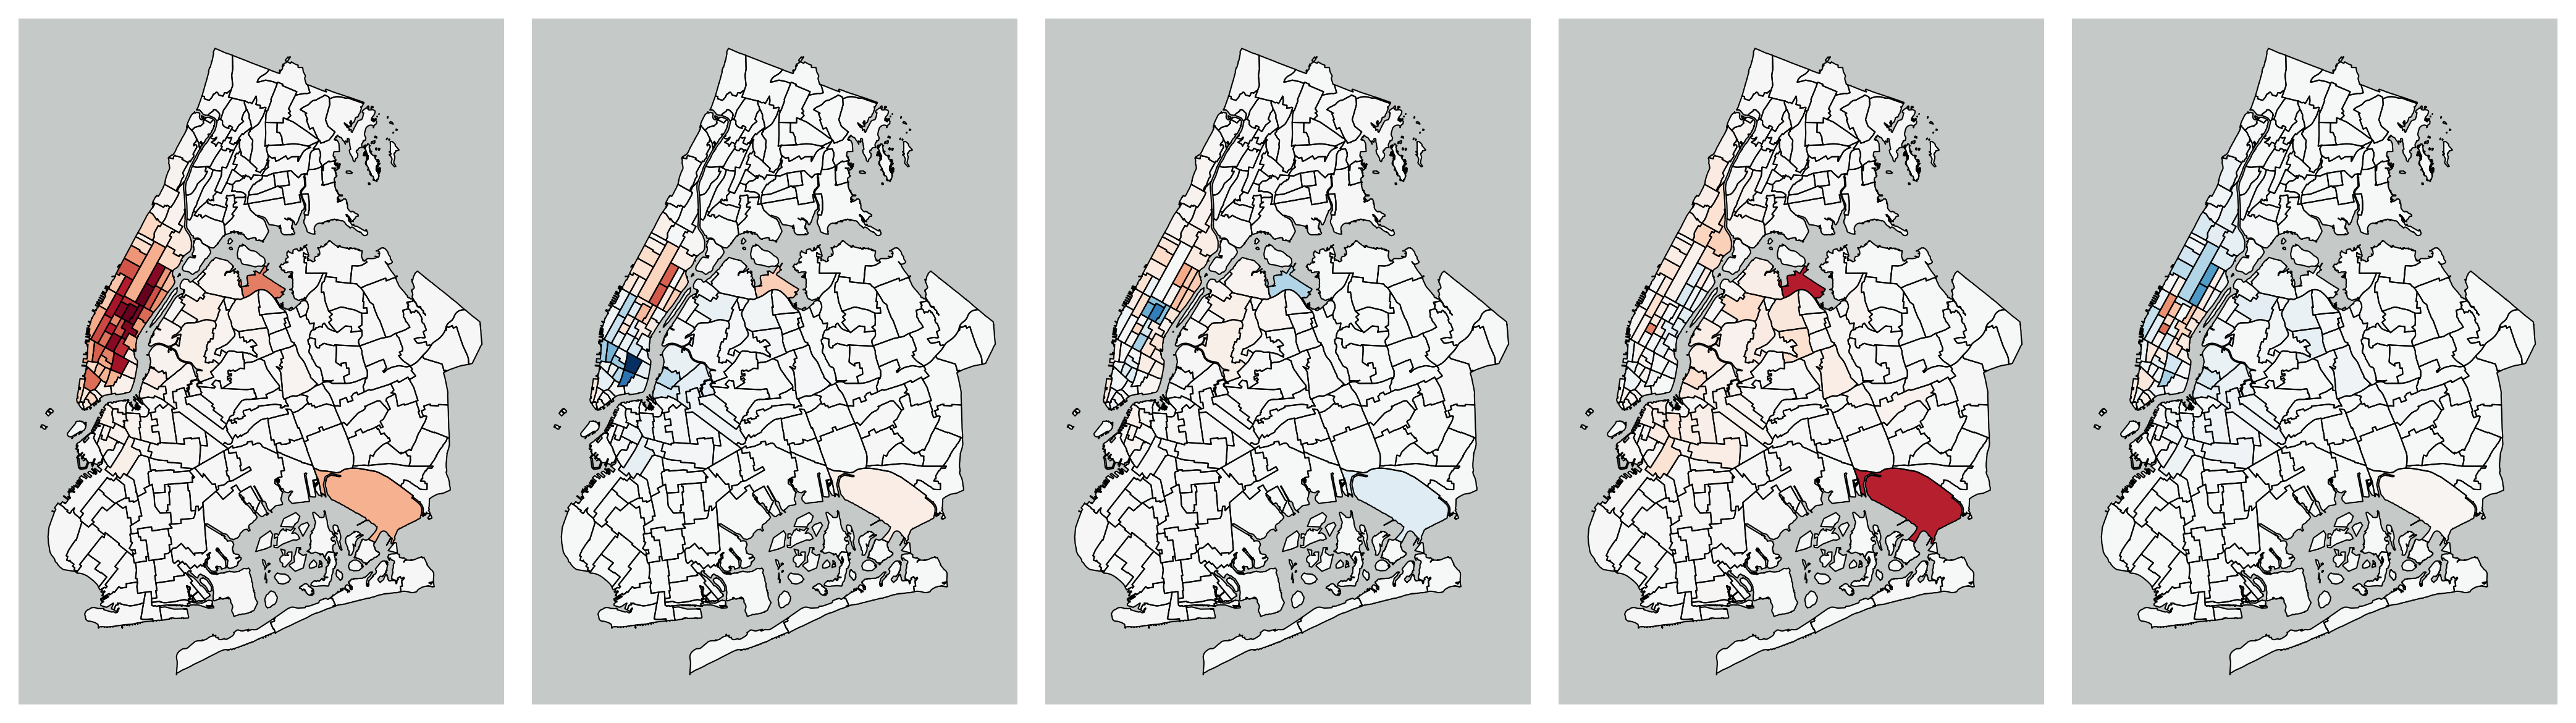

In [39]:
fig, axlist = plt.subplots(1, 5)
for i, ax in enumerate(axlist.ravel()):
    tzdf2.plot(figsize=(8, 8), alpha=1, column='pEOF{}'.format(i+1), cmap=plt.cm.RdBu, edgecolor='k',
          linewidth=0.5, vmin=-0.2e6/(i+1), vmax=0.2e6/(i+1), ax=ax)
    ax.grid(False)
    ax.set_facecolor('xkcd:silver')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect('equal', 'datalim')
fig.set_size_inches(14, 4)
plt.tight_layout()

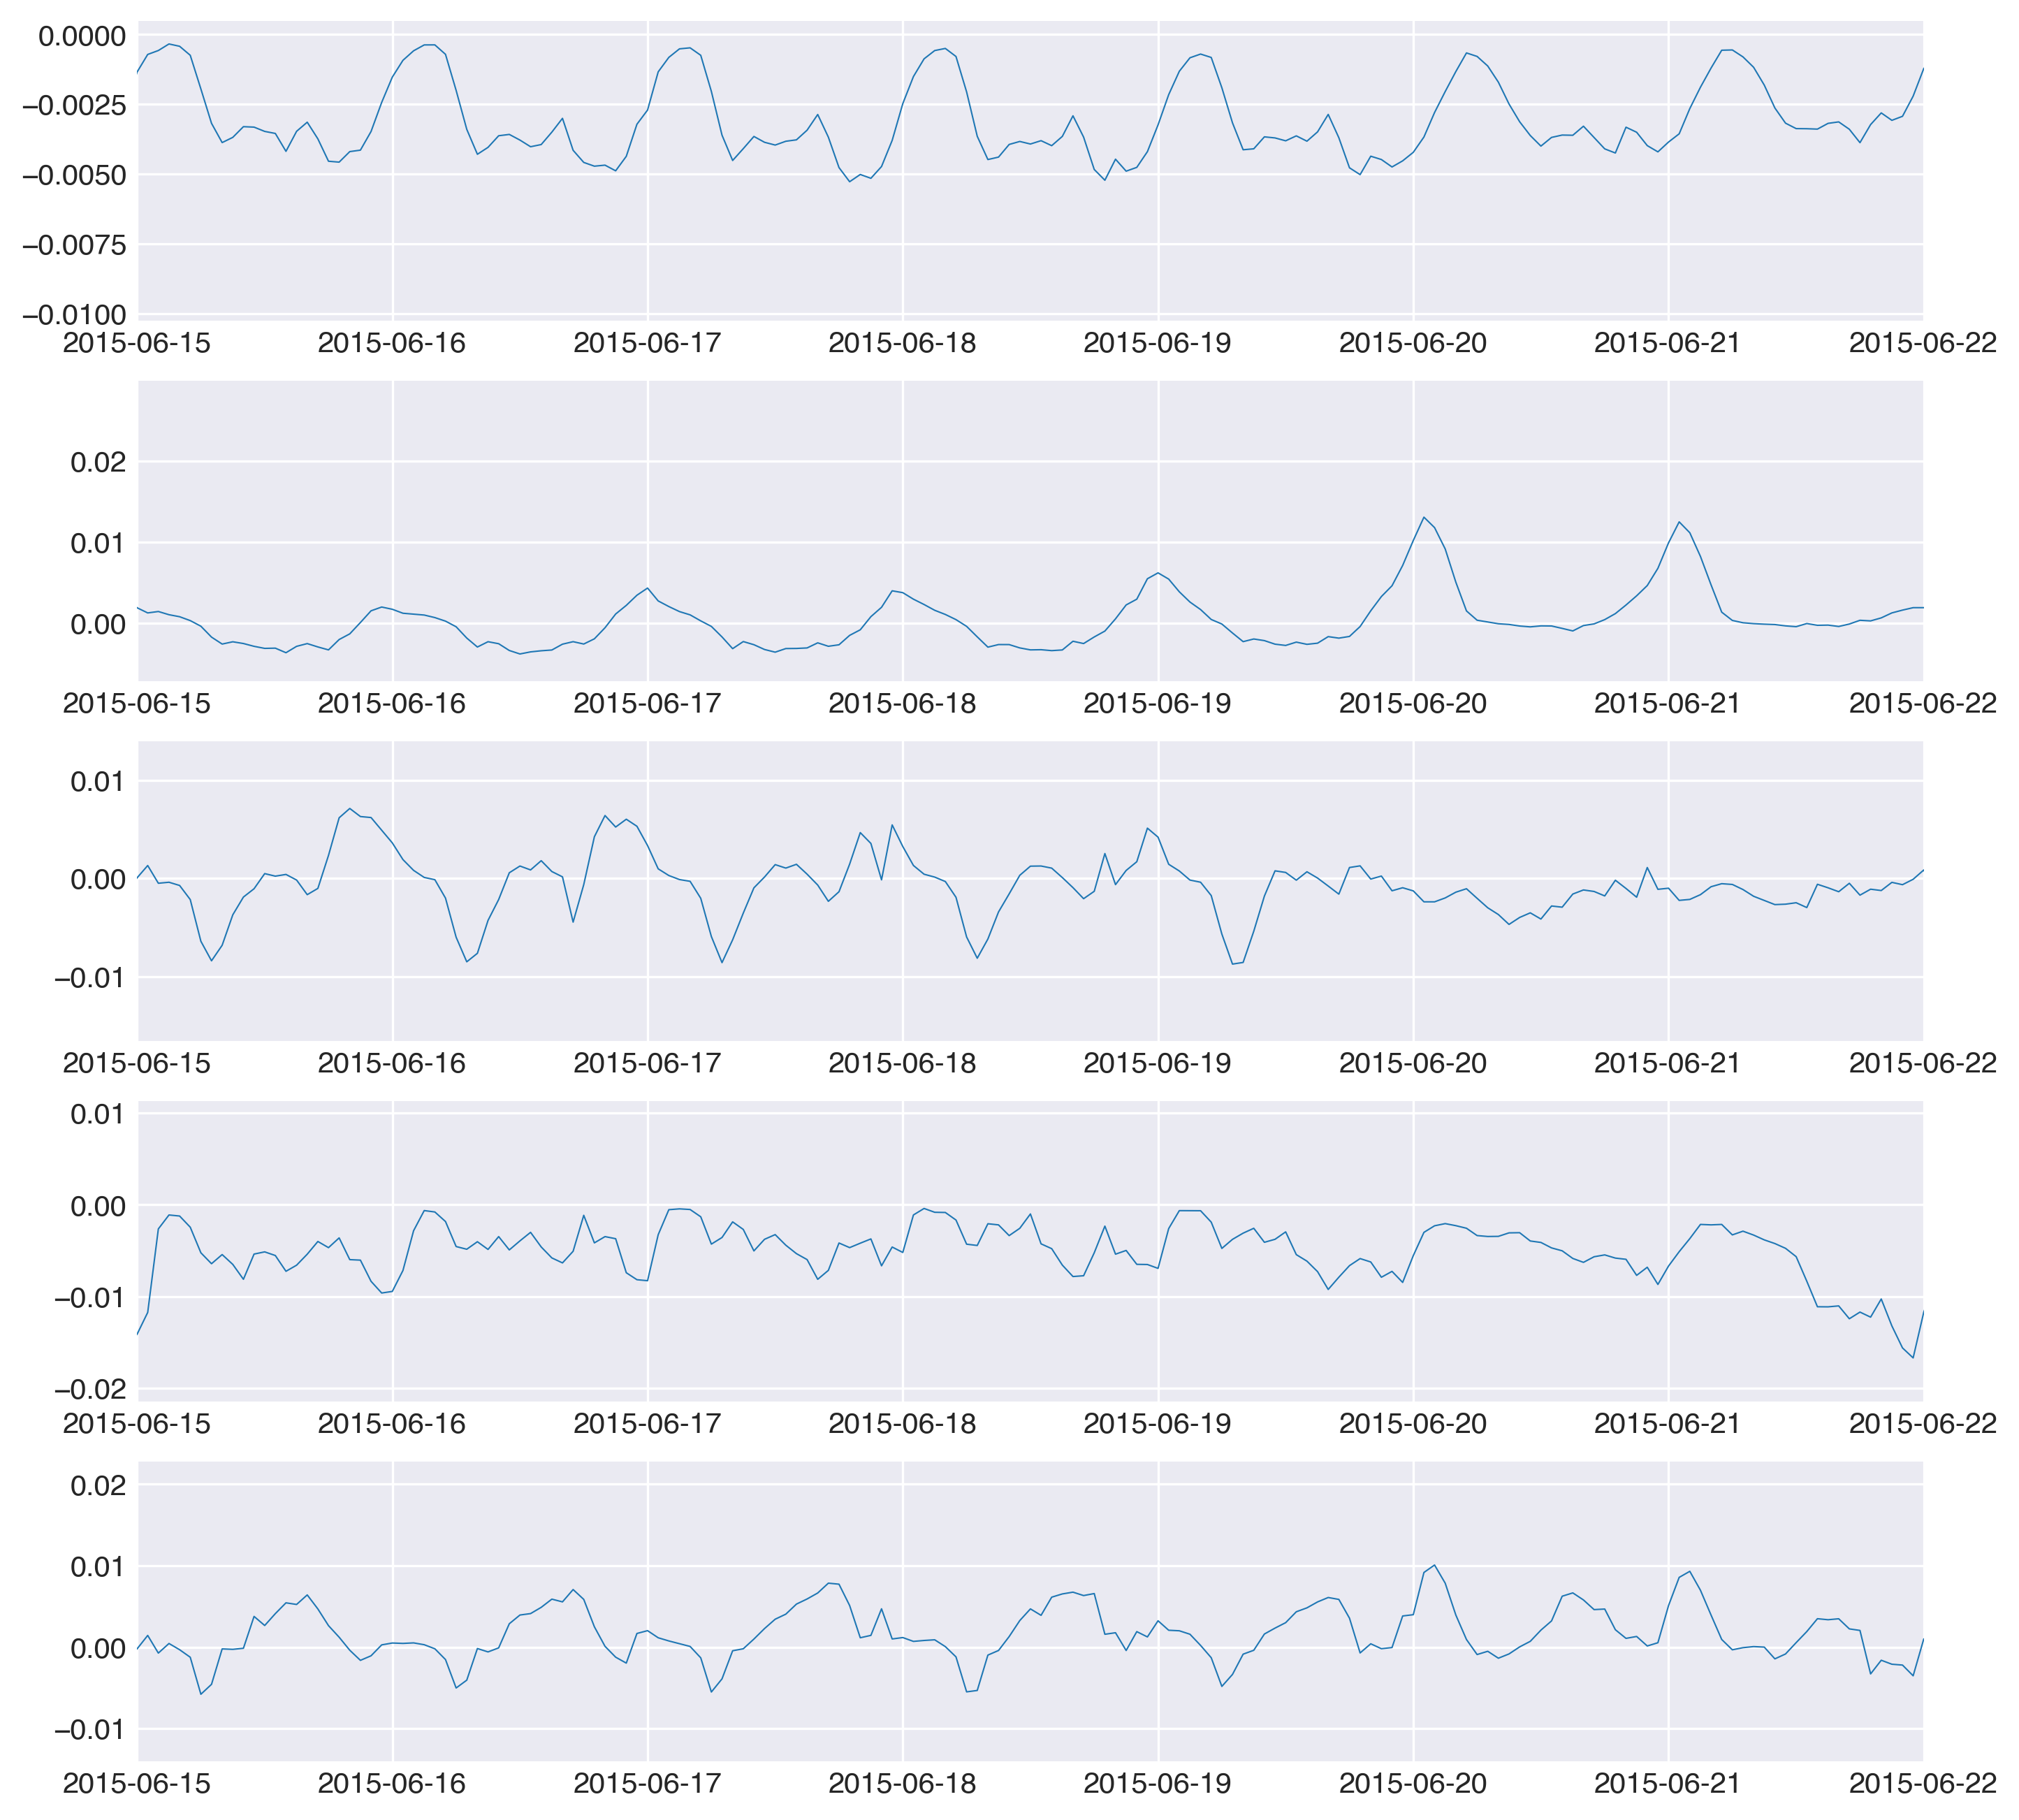

In [40]:
for i, y in enumerate(pickups_pcs.T[:]):
    plt.subplot(5, 1, i+1)
    plt.plot(pickups_matrix.index.values, y, label='pc{}'.format(i+1), lw=0.5)
    plt.xlim('2015-06-15', '2015-06-22')
plt.gcf().set_size_inches(11, 11)
# plt.xlim('2014-01-01', '2014-07-01')

### Poisson PCA

#### Direct R code : Requires running notebook with R kernel

In [1]:
pickups_matrix <- read.csv("/data/pickups_matrix.csv")
dropoffs_matrix <- read.csv("/data/trips_dropoffs_matrix.csv")
counts_matrix <- read.csv("/data/counts_matrix.csv")

In [2]:
data.matrix(head(pickups_matrix))

X1 X2 X3 X4  X5 X6 X7  X8 X9 X10 ⋯ X254 X255 X256 X257 X258 X259 X260 X261
1 0  0  0  121 0  0   42 0  0  0   ⋯ 0     74   53  4    2    0     6   70  
2 1  0  0  137 0  0   88 0  0  0   ⋯ 0     97   92  7    0    0    22   85  
3 1  0  0  125 0  0  115 0  0  0   ⋯ 0    122  115  6    1    0    21   55  
4 0  0  0  124 0  0  110 1  1  0   ⋯ 0     80   98  5    1    0    28   70  
5 2  0  0  100 0  0  105 0  1  0   ⋯ 0     80   74  5    0    0    20   37  
6 1  0  0   51 0  0   66 0  0  0   ⋯ 0     58   37  1    2    0    24   17  
  X262 X263
1 179  449 
2 239  627 
3 170  594 
4  96  437 
5  62  296 
6  26  120

In [36]:
library("generalizedPCA")
library(jsonlite)

In [12]:
k_pickups <- generalizedPCA(data.matrix(pickups_matrix), k=3, family="poisson", quiet=FALSE, max_iters=200)

0    4.620588 0 hours elapsed
1    4.537463 0 hours elapsed. Max 0.3 hours remain.
2    4.497068 0 hours elapsed. Max 0.3 hours remain.
3    4.467757 0 hours elapsed. Max 0.3 hours remain.
4    4.44437 0 hours elapsed. Max 0.3 hours remain.
5    4.424864 0 hours elapsed. Max 0.3 hours remain.
6    4.408139 0 hours elapsed. Max 0.3 hours remain.
7    4.39349 0 hours elapsed. Max 0.3 hours remain.
8    4.380426 0 hours elapsed. Max 0.3 hours remain.
9    4.368588 0.1 hours elapsed. Max 0.2 hours remain.
10    4.357714 0.1 hours elapsed. Max 0.2 hours remain.
11    4.347608 0.1 hours elapsed. Max 0.2 hours remain.
12    4.338124 0.1 hours elapsed. Max 0.2 hours remain.
13    4.329153 0.1 hours elapsed. Max 0.2 hours remain.
14    4.320613 0.1 hours elapsed. Max 0.2 hours remain.
15    4.312441 0.1 hours elapsed. Max 0.2 hours remain.
16    4.304587 0.1 hours elapsed. Max 0.2 hours remain.
17    4.297015 0.1 hours elapsed. Max 0.2 hours remain.
18    4.289695 0.1 hours elapsed. Max 0.2 hou

In [13]:
attributes(k_pickups)

$names
[1] "mu"                 "U"                  "PCs"               
[4] "M"                  "family"             "iters"             
[7] "loss_trace"         "prop_deviance_expl"

$class
[1] "gpca"

In [ ]:
k_pickups$prop_deviance_expl

In [32]:
write.csv(k_pickups$mu, file="/data/poisson_pca/pickups_mu.csv")
write.csv(k_pickups$U, file="/data/poisson_pca/pickups_U.csv")
write.csv(k_pickups$PCs, file="/data/poisson_pca/pickups_PCs.csv")
write.csv(k_pickups$loss_trace, file="/data/poisson_pca/pickups_loss_trace.csv")
write.csv(k_pickups$)
write(serializeJSON(k_pickups, pretty=TRUE), file="/data/poisson_pca/pickups.json")

In [ ]:
k_dropoffs <- generalizedPCA(data.matrix(dropoffs_matrix), k=3, family="poisson", quiet=FALSE, max_iters=200)

In [ ]:
write.csv(k_dropoffs$mu, file="/data/poisson_pca/dropoffs_mu.csv")
write.csv(k_dropoffs$U, file="/data/poisson_pca/dropoffs_U.csv")
write.csv(k_dropoffs$PCs, file="/data/poisson_pca/dropoffs_PCs.csv")
write.csv(k_dropoffs$loss_trace, file="/data/poisson_pca/dropoffs_loss_trace.csv")
write.csv(k_dropoffs$)
write(serializeJSON(k_dropoffs, pretty=TRUE), file="/data/poisson_pca/dropoffs.json")

In [ ]:
k_dropoffs$prop_deviance_expl

In [ ]:
k_counts <- generalizedPCA(data.matrix(counts_matrix), k=3, family="poisson", quiet=FALSE, max_iters=200)

In [ ]:
write.csv(k_counts$mu, file="/data/poisson_pca/counts_mu.csv")
write.csv(k_counts$U, file="/data/poisson_pca/counts_U.csv")
write.csv(k_counts$PCs, file="/data/poisson_pca/counts_PCs.csv")
write.csv(k_counts$loss_trace, file="/data/poisson_pca/counts_loss_trace.csv")
write.csv(k_counts$)
write(serializeJSON(k_counts, pretty=TRUE), file="/data/poisson_pca/counts.json")

In [ ]:
k_counts$prop_deviance_expl